## Распознавание тональности комментария с помощью нейросети

#### импорт библиотек

In [3]:
import numpy as np

import pandas as pd

import nltk
from nltk.corpus import stopwords

from string import punctuation

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from keras.callbacks import Callback

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Загрузка датасета

In [5]:
df = pd.read_csv("labeled.csv")

In [6]:
df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [7]:
df.describe(include='all')

,comment,toxic
count,14412,14412.000000
unique,14412,NaN
top,"Верблюдов-то за что? Дебилы, бл...\n",NaN
freq,1,NaN
mean,NaN,0.334860
std,NaN,0.471958
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


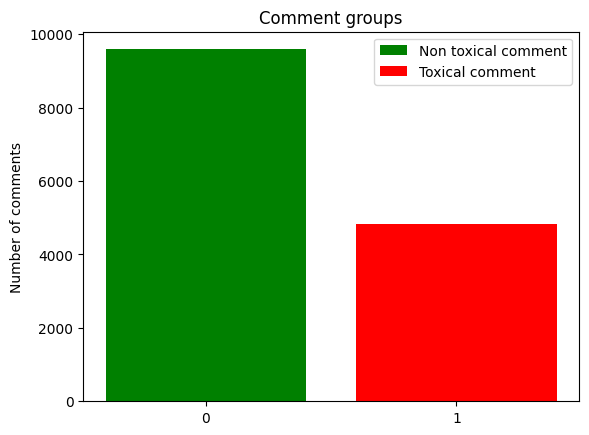

In [9]:
desc = df.groupby('toxic').describe()

plt.bar('0', desc['comment']['count'][0], label="Non toxical comment", color='green')
plt.bar('1', desc['comment']['count'][1], label="Toxical comment", color='red')
plt.legend()
plt.ylabel('Number of comments')
plt.title('Comment groups')
plt.show()

In [10]:
df[df["toxic"]==0].shape[0]

9586

In [11]:
df[df["toxic"]==1].shape[0]

4826

### Предобработка текста

In [13]:
import string
punct = string.punctuation+'—'+"“"+"”"+"»"+"«"+"\n"

удаляем пунктуацию, цифры и латинские символы, приводим к нижнему регистру

In [15]:
def remove_punctuation(text):
    text = re.sub(r"http\S+", "url", text)
    text = text.replace('ё', 'е')
    text = re.sub('[^a-zA-Zа-яА-Я]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()
    text = re.sub(r"[0-9" + re.escape(punct) + r"]+", " ", text)
    return text.lower()

In [16]:
df['prep_text'] = [remove_punctuation(text) for text in df['comment']]

In [17]:
df

,comment,toxic,prep_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдов то за что дебилы бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,вонючий совковый скот прибежал и ноет а вот и ...
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,а кого любить гоблина тупорылого что ли или ка...
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,посмотрел утомленных солнцем и оказалось что э...
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,крымотред нарушает правила раздела т к в нем н...


In [18]:
russian_stopwords = stopwords.words("russian") 
russian_stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [19]:
russian_stopwords.extend(['т.д.', 'т', 'д', 'это','который','свой','своём','всем','всё','её','оба','ещё','должный','всякий']) 

## Лемматизация

In [21]:
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

morph = pymorphy3.MorphAnalyzer(lang = 'ru')
russian_stopwords = set(russian_stopwords)


def process_text(text):
    try:
        tokens = [token for token in word_tokenize(text)  ]
        
        lemmas = []
        for word in tokens:
            parsed = morph.parse(word)
            if parsed and parsed[0].normal_form not in russian_stopwords:
                lemmas.append(parsed[0].normal_form)
        
        return (
            ' '.join(tokens),  # tokenized
            ' '.join(lemmas)   # lemmatized
        )
         
    
    except Exception as e:
        print(f"Error: {e} | Text: {text[:50]}")
        return ('', '')

results = df['prep_text'].apply(process_text)
df['text_lemm'] = [r[1] for r in results]

In [22]:
df["text_lemm"].isnull().sum()

0

### Облако слов

In [24]:
from wordcloud import WordCloud, STOPWORDS
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=russian_stopwords,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

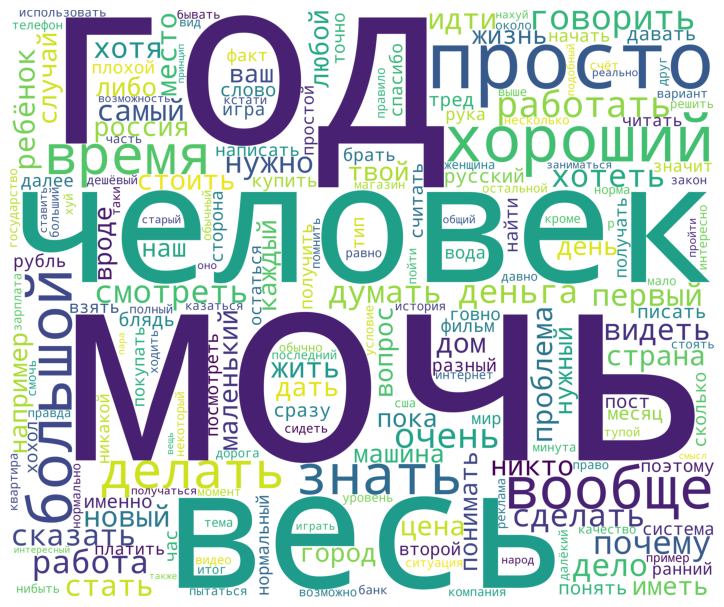

In [25]:
corpus = get_corpus(df['text_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

In [26]:
df

,comment,toxic,prep_text,text_lemm
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдов то за что дебилы бл,верблюд дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохол отдушина затюканый россиянин мол вон хох...
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собака собачий смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страница обновить дебил оскорбление доказать ф...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедить страничный пдф скрипаль отравить росси...
...,...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,вонючий совковый скот прибежал и ноет а вот и ...,вонючий совковый скот прибежать ныть сторонник...
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,а кого любить гоблина тупорылого что ли или ка...,любить гоблин тупорылый нибыть продажный сука ...
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,посмотрел утомленных солнцем и оказалось что э...,посмотреть утомлённый солнце оказаться хороший...
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,крымотред нарушает правила раздела т к в нем н...,крымотред нарушать правило раздел немой обсужд...


In [27]:
df[df['text_lemm'].str.len() == 0]

,comment,toxic,prep_text,text_lemm
1489,Потому что тут все его.,0.0,потому что тут все его,
8433,А-А-А-А-А-А--А-А!!!!!!!\n,1.0,а а а а а а а а,


In [28]:
df = df[df['text_lemm'].str.len() != 0]
df

,comment,toxic,prep_text,text_lemm
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдов то за что дебилы бл,верблюд дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохол отдушина затюканый россиянин мол вон хох...
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собака собачий смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страница обновить дебил оскорбление доказать ф...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедить страничный пдф скрипаль отравить росси...
...,...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,вонючий совковый скот прибежал и ноет а вот и ...,вонючий совковый скот прибежать ныть сторонник...
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,а кого любить гоблина тупорылого что ли или ка...,любить гоблин тупорылый нибыть продажный сука ...
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,посмотрел утомленных солнцем и оказалось что э...,посмотреть утомлённый солнце оказаться хороший...
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,крымотред нарушает правила раздела т к в нем н...,крымотред нарушать правило раздел немой обсужд...


## Предсказание

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import train_test_split

In [31]:
df[df["toxic"]==0].shape[0]

9585

In [32]:
df[df["toxic"]==1].shape[0]

4825

была проведена балансировка классов, уменьшением превалирующего класса

In [115]:
from sklearn.utils import resample
df_class_0 = df[df["toxic"] == 0]
df_class_1 = df[df["toxic"] == 1]


n_samples = min(len(df_class_0), len(df_class_1))

df_class_0_downsampled = resample(df_class_0,
                                 replace=False,
                                 n_samples=n_samples,
                                 random_state=42)
df_balanced = pd.concat([df_class_0_downsampled, df_class_1])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [121]:
df_balanced[df_balanced["toxic"]==1].shape[0]

4825

In [123]:
y = df_balanced['toxic']
X = df_balanced['text_lemm']
# y = df["toxic"]
# X = df['text_lemm']

### Разделение выборки

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30, 
                                                    random_state=0)

In [130]:
X_train

8288    наслать богиня ёбаный рот хуя урод раздел нужн...
6122    ежемесячный пособие составлять среднее заробот...
4654    типовой ошибка симптом предлагать препарат иск...
1343    заставить зуб расти определённый место заменят...
917     хз холопошизика спрашивать макака зваться мака...
                              ...                        
7891    евген точно тред сидеть рассказывать клэп горл...
9225    судить описать ситуация повторяться год год пу...
4859    объяснить браковать кот гарантия попытаться об...
3264    бабуля хиккан иллюминат донецкий друг кувиковы...
2732                          слепой лошадь разбег стожок
Name: text_lemm, Length: 6755, dtype: object

In [132]:
X_test.shape[0]

2895

In [134]:
y_test

1070    0.0
4488    0.0
8763    1.0
7372    0.0
7633    0.0
       ... 
6475    0.0
3453    1.0
3326    1.0
3169    0.0
5354    1.0
Name: toxic, Length: 2895, dtype: float64

### Токенизация

In [136]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size = 25000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)


In [137]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

### Приведение к общему размеру

In [141]:
from keras.preprocessing.sequence import pad_sequences
max_comment_length = 250
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_comment_length)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_comment_length)

### LSTM-CNN модель

In [144]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import  Dropout, BatchNormalization

In [180]:
model = tf.keras.Sequential([
    
    Embedding(
    input_dim=vocab_size,
    output_dim=300,
    input_length=max_comment_length, 
    trainable=True, 
    name='embedding_layer'
),
     LSTM(
    units=30,
    return_sequences=True,  # возвращаем последовательности для Conv1D
    name='lstm_layer'
),
    Conv1D(
    filters=64,
    kernel_size=3,
    padding='same',
    activation='relu',
    name='conv1d_1'
),
    BatchNormalization(name='batch_norm'),

 GlobalMaxPooling1D(
    name='global_max_pooling1d'
)
,
 tf.keras.layers.Dropout(0.5, name='dropout_1'),
    tf.keras.layers.Dense(50, activation='leaky_relu', name='dense_1'),
    tf.keras.layers.Dropout(0.4, name='dropout_2'),
    

    tf.keras.layers.Dense(1, activation='sigmoid', name='output'),
])

In [181]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [182]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 250, 300)          7500000   
 )                                                               
                                                                 
 lstm_layer (LSTM)           (None, 250, 30)           39720     
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 64)           5824      
                                                                 
 batch_norm (BatchNormaliza  (None, 250, 64)           256       
 tion)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                      

In [183]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [189]:
history = model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_test_padded, y_test), batch_size=32,callbacks = [early_stop])

Epoch 1/15
212/212 [==============================] - 60s 250ms/step - loss: 0.5618 - accuracy: 0.7016 - auc: 0.7873 - val_loss: 0.6198 - val_accuracy: 0.7164 - val_auc: 0.9190
Epoch 2/15
212/212 [==============================] - 50s 236ms/step - loss: 0.2309 - accuracy: 0.9135 - auc: 0.9686 - val_loss: 0.4790 - val_accuracy: 0.7948 - val_auc: 0.9228
Epoch 3/15
212/212 [==============================] - 50s 237ms/step - loss: 0.0852 - accuracy: 0.9754 - auc: 0.9945 - val_loss: 0.4420 - val_accuracy: 0.8273 - val_auc: 0.9168
Epoch 4/15
212/212 [==============================] - 51s 243ms/step - loss: 0.0342 - accuracy: 0.9905 - auc: 0.9986 - val_loss: 0.7340 - val_accuracy: 0.8183 - val_auc: 0.9072
Epoch 5/15
212/212 [==============================] - 49s 233ms/step - loss: 0.0243 - accuracy: 0.9945 - auc: 0.9989 - val_loss: 0.8796 - val_accuracy: 0.8131 - val_auc: 0.8972
Epoch 6/15
212/212 [==============================] - 54s 255ms/step - loss: 0.0187 - accuracy: 0.9959 - auc: 0.999

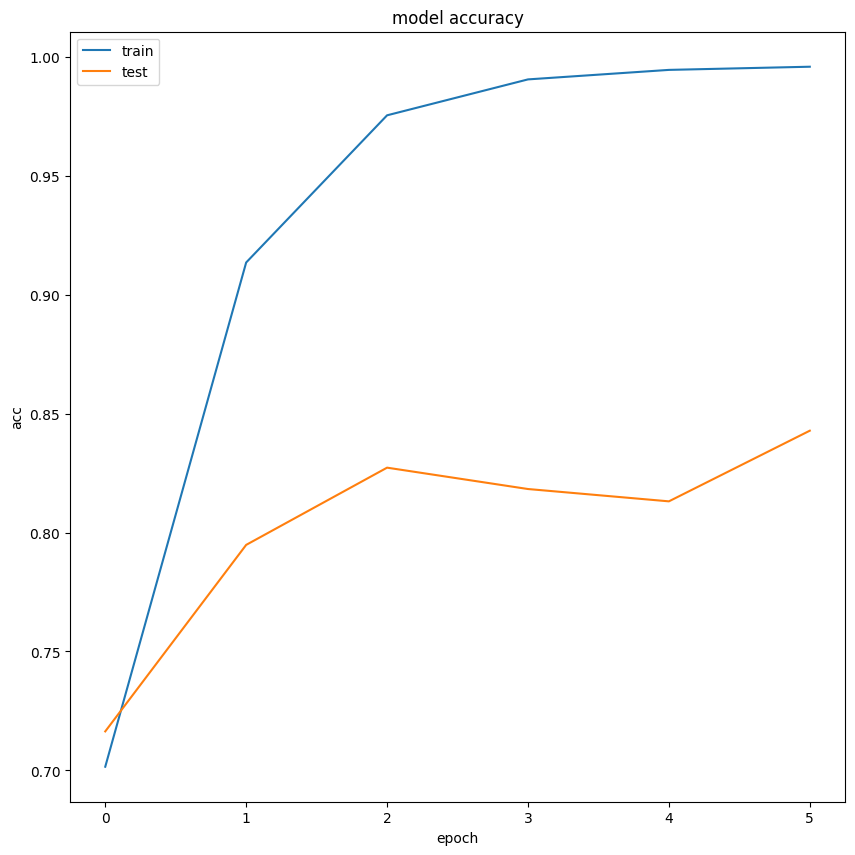

In [190]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

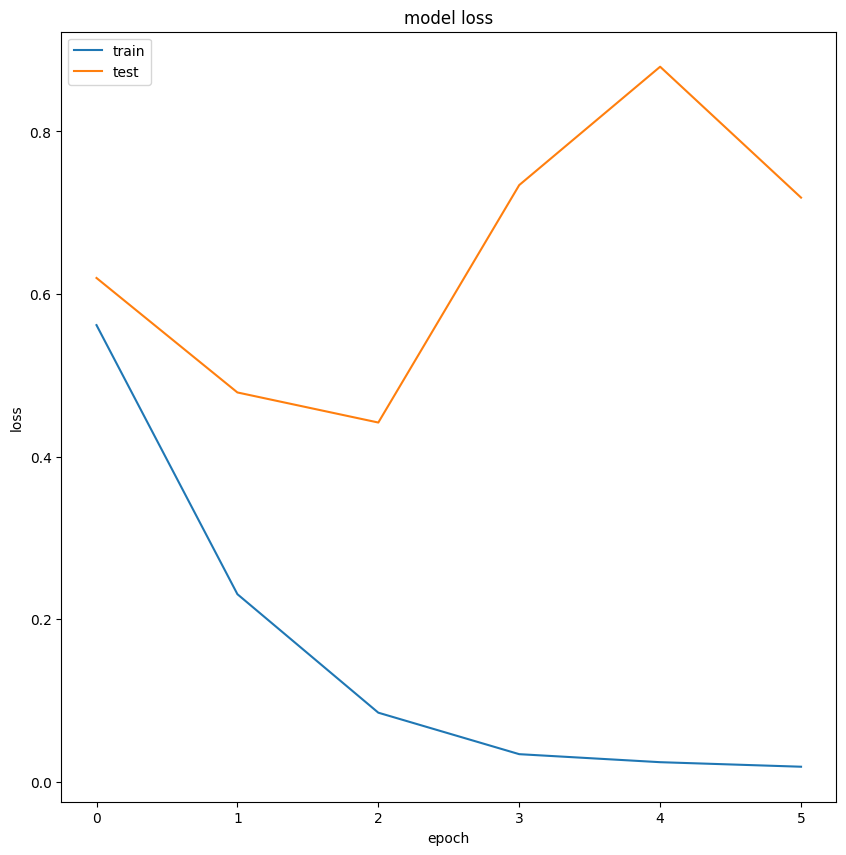

In [191]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [195]:
predictions = model.predict(X_test_padded)
predicted_classes = np.round(predictions).astype(int)
predicted_classes

91/91 [==============================] - 5s 47ms/step


array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [196]:
print(classification_report(y_test, predicted_classes, zero_division=True))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      1455
         1.0       0.84      0.85      0.84      1440

    accuracy                           0.84      2895
   macro avg       0.84      0.84      0.84      2895
weighted avg       0.84      0.84      0.84      2895



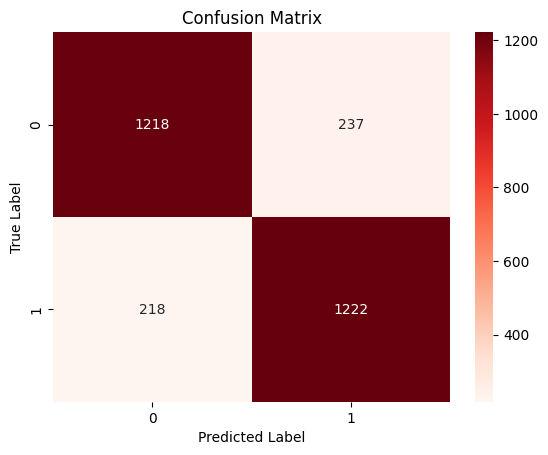

In [199]:
cm = confusion_matrix(y_test, predicted_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [202]:
example = 'вот как бывает'
clean_example = remove_punctuation(example)
lemm_example = process_text(clean_example)[1]
array_example = np.array([lemm_example])
seq_example = tokenizer.texts_to_sequences(array_example)
pad_example = pad_sequences(seq_example, maxlen=max_comment_length)
pred_example = model.predict(pad_example)
print(round(pred_example[0][0]))

1/1 [==============================] - 0s 69ms/step
0


### Загрузка моделей

In [204]:
import pickle

with open('classifier_model1.pkl', 'wb') as file:
    pickle.dump(model, file)
    # 
with open('tokenizer1.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)